In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

#import matplotlib as mpl
import matplotlib.pyplot as plt
#import matplotlib.dates as mdates
%matplotlib inline 

from tqdm import tqdm_notebook
from itertools import product

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import gc

In [2]:
DATA_FOLDER = './data/'

sales = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))
items = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))

In [3]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [4]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

In [5]:
def create_grid(sales, index_cols):
    from tqdm import tqdm_notebook
    
    # For every month we create a grid from all shops/items combinations from that month
    grid = [] 
    for block_num in tqdm_notebook(sales['date_block_num'].unique()):
        cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
        cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
        grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

    # Turn the grid into a dataframe
    grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

    # Groupby data to get shop-item-month aggregates
    gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
    # Fix column names
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
    # Clip
    gb.target = gb.target.clip(0,20) #TODO
    # Join it to the grid    
    all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

    # Same as above but with shop-month aggregates
    gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

    # Same as above but with item-month aggregates
    gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
    gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

    # Same as above but with category-month aggregates
    item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()
    all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
    
    gb = pd.merge(sales, item_category_mapping, how='left', on='item_id')
    gb = gb.groupby(['item_category_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_category':'sum'}})
    gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=['item_category_id', 'date_block_num']).fillna(0)

    # Downcast dtypes from 64 to 32 bit to save memory
    all_data = downcast_dtypes(all_data)
    del grid, gb 
    gc.collect();
    
    return all_data

In [6]:
max_train_date_block_num = sales.date_block_num.max()
max_train_date_block_num

33

In [7]:
all_data = create_grid(
    pd.concat(
        [sales, test.assign(date_block_num=max_train_date_block_num+1)],
        ignore_index=True, sort=False),
    index_cols)
all_data.head()

/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/groupby/groupby.py:4658: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,shop_id,item_id,date_block_num,target,target_shop,target_item,item_category_id,target_category
0,59,22154,0,1.0,2017.0,18.0,37,6094.0
1,59,2552,0,0.0,2017.0,0.0,58,287.0
2,59,2554,0,0.0,2017.0,1.0,58,287.0
3,59,2555,0,0.0,2017.0,2.0,56,268.0
4,59,2564,0,0.0,2017.0,5.0,59,701.0


In [8]:
def create_lags(all_data, shift_range = [1, 2, 3, 4, 5, 12]):

    # List of columns that we will use to create lags
    cols_to_rename = list(all_data.columns.difference(index_cols)) 

    for month_shift in tqdm_notebook(shift_range):
        train_shift = all_data[index_cols + cols_to_rename].copy()

        train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift

        foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
        train_shift = train_shift.rename(columns=foo)

        all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

    del train_shift

    # List of all lagged features
    fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
    # We will drop these at fitting stage
    to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

    all_data = downcast_dtypes(all_data)
    gc.collect();
    
    return all_data, to_drop_cols

In [9]:
lagged_data, to_drop_cols = create_lags(all_data)
lagged_data.head()
to_drop_cols

,shop_id,item_id,date_block_num,target,target_shop,target_item,item_category_id,target_category,item_category_id_lag_1,target_lag_1,target_category_lag_1,target_item_lag_1,target_shop_lag_1,item_category_id_lag_2,target_lag_2,target_category_lag_2,target_item_lag_2,target_shop_lag_2,item_category_id_lag_3,target_lag_3,target_category_lag_3,target_item_lag_3,target_shop_lag_3,item_category_id_lag_4,target_lag_4,target_category_lag_4,target_item_lag_4,target_shop_lag_4,item_category_id_lag_5,target_lag_5,target_category_lag_5,target_item_lag_5,target_shop_lag_5,item_category_id_lag_12,target_lag_12,target_category_lag_12,target_item_lag_12,target_shop_lag_12
0,59,22154,0,1.0,2017.0,18.0,37,6094.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,59,2552,0,0.0,2017.0,0.0,58,287.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,59,2554,0,0.0,2017.0,1.0,58,287.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,59,2555,0,0.0,2017.0,2.0,56,268.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,59,2564,0,0.0,2017.0,5.0,59,701.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


['item_category_id',
 'target_item',
 'target_category',
 'target_shop',
 'target',
 'date_block_num']

In [10]:
# TODO shop_id one-hot encoding, category_id one-hot encoding

In [11]:
train = lagged_data.loc[lagged_data.date_block_num <= max_train_date_block_num]
test_lagged = lagged_data.loc[lagged_data.date_block_num == max_train_date_block_num + 1]

In [12]:
# TODO
#train = train.loc[train.shop_id.isin([26, 27, 28])]

In [13]:
X_train = train.drop(to_drop_cols, axis=1).values
print(X_train) #X.head()

[[5.9000e+01 2.2154e+04 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [5.9000e+01 2.5520e+03 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [5.9000e+01 2.5540e+03 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 ...
 [2.1000e+01 7.6400e+03 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [2.1000e+01 7.6320e+03 6.4000e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [2.1000e+01 7.4400e+03 5.7000e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]]


In [14]:
target_col = 'target'
y_train = train.loc[:, [target_col]].values.ravel()
print(y_train) #y.head()

[1. 0. 0. ... 0. 0. 0.]


In [19]:
def gen_time_split(data, n_splits):
    for i in range(n_splits):
        #print(i)
        first_vali_date_block_num = max_train_date_block_num - i
        vali_indices = data.loc[:,'date_block_num'] == first_vali_date_block_num
        train_indices = data.loc[:,'date_block_num'] < first_vali_date_block_num
        yield (train_indices[train_indices].index.values, vali_indices[vali_indices].index.values)

In [ ]:
cv = gen_time_split(train, 3)
#for (tidx, vidx) in cv:
#    print(X_train[tidx])
#    print(X_train[vidx])
#    print(y_train[tidx])
#    print(y_train[vidx])
#for split in cv:
#    print(split)

In [ ]:
#lr = 1 / np.logspace(0.0, 1.0, num=5)[2:]
#lr = np.array([0.3, 0.45, 0.6])
#lr = np.linspace(0.3, 0.6, 5)
lr = np.array([0.3])
print(lr)

In [31]:
X_test = test.merge(test_lagged, how='left').drop(to_drop_cols + ['ID'], axis=1).values
print(X_test)

[[5.0000e+00 5.0370e+03 1.9000e+01 ... 6.1340e+03 6.5000e+01 1.4450e+03]
 [5.0000e+00 5.3200e+03 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [5.0000e+00 5.2330e+03 1.9000e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 ...
 [4.5000e+01 1.5757e+04 5.5000e+01 ... 9.8090e+03 9.0000e+00 1.2510e+03]
 [4.5000e+01 1.9648e+04 4.0000e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [4.5000e+01 9.6900e+02 3.7000e+01 ... 5.1850e+03 6.0000e+00 1.2510e+03]]


In [41]:
import xgboost as xgb
params = {'max_depth':7, 'eta':0.3, 'silent':0, 'objective':'reg:linear', 'eval_metric':'rmse'}
dtrain = xgb.DMatrix(X_train, label=y_train)

In [23]:
folds = [fold for fold in gen_time_split(train, 3)]
#print(folds)
eval_hist = xgb.cv(param, dtrain, num_boost_round=1000, folds=folds, metrics=['rmse'], early_stopping_rounds=10, verbose_eval=True)

[19:47:07] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[19:47:13] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=7
[19:47:14] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[19:47:20] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:47:20] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[19:47:26] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:1.11332+0.00171261	test-rmse:1.03136+0.0476726
[19:47:29] /mnt/xgboost/src/tree/updater_pru

[19:50:19] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=7
[17]	train-rmse:0.931332+0.0014403	test-rmse:0.891283+0.0657013
[19:50:22] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=7
[19:50:26] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=7
[19:50:29] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=7
[18]	train-rmse:0.930226+0.00170621	test-rmse:0.891187+0.0657465
[19:50:32] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=7
[19:50:35] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=7
[19:50:39] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, m

[19:53:24] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=7
[19:53:28] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=7
[36]	train-rmse:0.9113+0.00115378	test-rmse:0.889927+0.0668527
[19:53:31] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[19:53:34] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=7
[19:53:38] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=7
[37]	train-rmse:0.910378+0.00143628	test-rmse:0.889873+0.0668297
[19:53:41] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[19:53:44] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, ma

In [43]:
opt_num_rounds = eval_hist.shape[0]
#eval_hist

In [44]:
xgb_model = xgb.train(param, dtrain, num_boost_round=100)#opt_num_rounds)

[20:20:03] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[20:20:09] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=7
[20:20:13] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[20:20:16] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[20:20:20] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[20:20:23] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[20:20:27] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=7
[20:20:30] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 

[20:23:48] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=7
[20:23:52] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=7
[20:23:55] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[20:23:58] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[20:24:02] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=7
[20:24:06] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[20:24:09] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=7
[20:24:13] /mnt/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_

In [45]:
from sklearn.metrics import mean_squared_error, r2_score
y_train_pred_xgb = xgb_model.predict(dtrain)
print('RMSE for XGBoost is %f' % np.sqrt(mean_squared_error(y_train, y_train_pred_xgb)))
print('Train R-squared for XGBoost is %f' % r2_score(y_train, y_train_pred_xgb))

RMSE for XGBoost is 0.869361
Train R-squared for XGBoost is 0.494184


0.7452304
0.86326724
Train R-squared for XGBoost is 0.501250

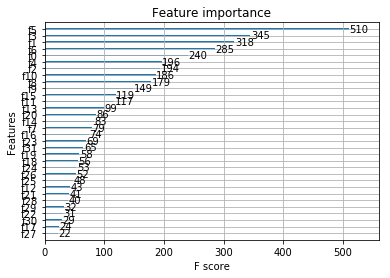

In [40]:
from xgboost import plot_importance
plot_importance(xgb_model)

In [32]:
# make prediction
dtest = xgb.DMatrix(X_test)
y_test_pred_xgb = xgb_model.predict(dtest)
print(y_test_pred_xgb)

[0.32977834 0.32160562 0.9969541  ... 0.02822068 0.01780385 0.03059867]


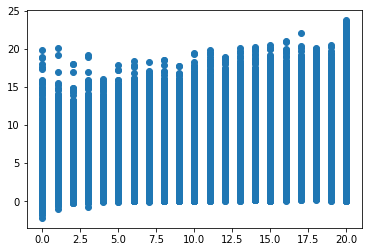

In [37]:
plt.scatter(y_train, y_train_pred_xgb)

In [46]:
submission = test.assign(item_cnt_month=y_test_pred_xgb)[['item_cnt_month']]
submission.describe()

,item_cnt_month
count,214200.000000
mean,0.262804
std,0.689662
min,-0.480637
25%,0.034385
50%,0.109417
75%,0.291892
max,21.314077


In [48]:
submission.to_csv('Ensemble2.csv', index_label='ID') #header=['ID', 'item_cnt_month'])

In [49]:
!gzip Ensemble2.csv
!ls

Baseline.ipynb	Ensemble2.csv.gz  Refactor.ipynb
Combos.ipynb	Ensemble.csv.gz   RefactorXGB.csv.gz
data		Ensemble.ipynb	  Shop and item category means.ipynb
EDA.ipynb	Lagged.ipynb


In [50]:
X_train.shape

(10913850, 32)

In [56]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

def create_keras_model():
    model = Sequential()
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

keras_estimator = KerasRegressor(build_fn=create_keras_model, epochs=10, batch_size=1000, verbose=True)
#results = cross_val_score(estimator, X_train, Y_train, cv=gen_time_split(train, 3))
model_keras = keras_estimator.fit(X_train, y_train)

Epoch 1/10
10913850/10913850 [==============================] - 51s 5us/step - loss: 2611.1234
Epoch 2/10
10913850/10913850 [==============================] - 50s 5us/step - loss: 36.4130
Epoch 3/10
10913850/10913850 [==============================] - 50s 5us/step - loss: 2.1719
Epoch 4/10
10913850/10913850 [==============================] - 50s 5us/step - loss: 0.9972
Epoch 5/10
10913850/10913850 [==============================] - 50s 5us/step - loss: 0.9821
Epoch 6/10
10913850/10913850 [==============================] - 50s 5us/step - loss: 0.9802
Epoch 7/10
10913850/10913850 [==============================] - 50s 5us/step - loss: 0.9679
Epoch 8/10
10913850/10913850 [==============================] - 50s 5us/step - loss: 0.9631
Epoch 9/10
10913850/10913850 [==============================] - 51s 5us/step - loss: 0.9596
Epoch 10/10
10913850/10913850 [==============================] - 50s 5us/step - loss: 0.9548


In [57]:
from sklearn.metrics import mean_squared_error, r2_score
y_train_pred_keras = keras_estimator.predict(X_train)
print('RMSE for Keras is %f' % np.sqrt(mean_squared_error(y_train, y_train_pred_keras)))
print('Train R-squared for Keras is %f' % r2_score(y_train, y_train_pred_keras))

10913850/10913850 [==============================] - 19s 2us/step
RMSE for Keras is 0.972380
Train R-squared for Keras is 0.367204
